In [1]:
# 04_error_deep_dive.ipynb
# Part 4: Deep Dive into Error Types

# Imports and Setup
from utils import *
from sklearn.cluster import AgglomerativeClustering

setup_plotting_style()
print_section_header("PART 4: ERROR TYPE DEEP DIVE")

# Load Data
df_models, df_class_stats, df_confusion = load_all_data()
pred_cols, all_classes = get_pred_columns(df_confusion)
total_models = df_confusion['model_name'].nunique()

print(f"Total Models: {total_models}")
print(f"Total Classes: {len(all_classes)}")


PART 4: ERROR TYPE DEEP DIVE
Total Models: 12
Total Classes: 38


In [2]:
# Build Error DataFrame
print_subsection_header("1. ANALYZING ERROR TYPES")

df_errors = build_error_frequency_df(df_confusion, pred_cols)

error_model_count = df_errors.groupby(['True_Class', 'Predicted_Class']).agg({
    'Model': 'nunique',
    'Count': ['sum', 'mean', 'std']
}).reset_index()

error_model_count.columns = ['True_Class', 'Predicted_Class', 'Num_Models', 
                              'Total_Count', 'Avg_Count', 'Std_Count']

# Categorize errors
hard_errors, moderate_errors, soft_errors = categorize_errors_by_frequency(
    error_model_count, total_models
)

print(f"\nERROR BREAKDOWN:")
print(f"  - Hard errors: {len(hard_errors)}")
print(f"  - Moderate errors: {len(moderate_errors)}")
print(f"  - Soft errors: {len(soft_errors)}")



--------------------------------------------------------------------------------
1. ANALYZING ERROR TYPES
--------------------------------------------------------------------------------

ERROR BREAKDOWN:
  - Hard errors: 41
  - Moderate errors: 10
  - Soft errors: 309


In [3]:
# Hard Errors
print_subsection_header("2. HARD ERRORS (SYSTEMATIC)")

hard_errors = hard_errors.sort_values('Total_Count', ascending=False)

print(f"\nTOP 20 HARD ERRORS:")
print(hard_errors[['True_Class', 'Predicted_Class', 'Total_Count']].head(20).to_string(index=False))



--------------------------------------------------------------------------------
2. HARD ERRORS (SYSTEMATIC)
--------------------------------------------------------------------------------

TOP 20 HARD ERRORS:
                                        True_Class                               Predicted_Class  Total_Count
       True_Tomato___Tomato_Yellow_Leaf_Curl_Virus        Tomato___Tomato_Yellow_Leaf_Curl_Virus        12709
     True_Orange___Haunglongbing_(Citrus_greening)      Orange___Haunglongbing_(Citrus_greening)        12685
                            True_Soybean___healthy                             Soybean___healthy        12404
                      True_Tomato___Bacterial_spot                       Tomato___Bacterial_spot         5090
                       True_Peach___Bacterial_spot                        Peach___Bacterial_spot         5040
                         True_Tomato___Late_blight                          Tomato___Late_blight         4718
                  

In [4]:
# Soft Errors
print_subsection_header("3. SOFT ERRORS (ENSEMBLE CANDIDATES)")

soft_errors = soft_errors.sort_values('Std_Count', ascending=False)

print(f"\nTOP 20 SOFT ERRORS:")
print(soft_errors[['True_Class', 'Predicted_Class', 'Num_Models', 'Std_Count']].head(20).to_string(index=False))

# Model specialization
print("\nMODEL SPECIALIZATION:")
for idx, error_pair in soft_errors.head(3).iterrows():
    true_cls = error_pair['True_Class']
    pred_cls = error_pair['Predicted_Class']
    
    models_with = df_errors[
        (df_errors['True_Class'] == true_cls) & 
        (df_errors['Predicted_Class'] == pred_cls)
    ]['Model'].unique()
    
    models_without = [m for m in df_confusion['model_name'].unique() 
                      if m not in models_with]
    
    print(f"\n  {truncate_label(true_cls, 25)} → {truncate_label(pred_cls, 25)}")
    print(f"  Making error: {', '.join(models_with)}")
    if models_without:
        print(f"  Avoiding error: {', '.join(models_without)}")



--------------------------------------------------------------------------------
3. SOFT ERRORS (ENSEMBLE CANDIDATES)
--------------------------------------------------------------------------------

TOP 20 SOFT ERRORS:
                                        True_Class                        Predicted_Class  Num_Models  Std_Count
                         True_Tomato___Late_blight                  Tomato___Early_blight           5   5.983310
                         True_Potato___Late_blight                  Potato___Early_blight           2   4.949747
                         True_Tomato___Target_Spot                       Tomato___healthy           2   4.242641
                            True_Soybean___healthy                 Pepper,_bell___healthy           3   4.041452
                  True_Tomato___Septoria_leaf_spot                     Tomato___Leaf_Mold           5   3.911521
                  True_Tomato___Septoria_leaf_spot                   Tomato___Target_Spot           2

In [5]:
# High-Confidence Errors
print_subsection_header("4. HIGH-CONFIDENCE ERRORS")

high_conf_analysis = df_models[['Model', 'High_Confidence_Errors', 
                                 'Avg_Confidence_Incorrect']].copy()
high_conf_analysis['Danger_Score'] = calculate_risk_score(df_models)
high_conf_analysis = high_conf_analysis.sort_values('Danger_Score', ascending=False)

print("\nDANGER SCORE RANKING:")
print(high_conf_analysis.to_string(index=False))



--------------------------------------------------------------------------------
4. HIGH-CONFIDENCE ERRORS
--------------------------------------------------------------------------------

DANGER SCORE RANKING:
           Model  High_Confidence_Errors  Avg_Confidence_Incorrect  Danger_Score
         AlexNet                     165                  0.694824    114.645996
           LeNet                     132                  0.751953     99.257812
     MobileNetV2                      52                  0.801758     41.691406
        ResNet34                      47                  0.823730     38.715332
MobileNetV3Small                      45                  0.834473     37.551270
  EfficientNetB0                      41                  0.823730     33.772949
        ResNet18                      38                  0.812500     30.875000
        ResNet50                      36                  0.818848     29.478516
     DenseNet121                      29                  0

In [6]:
# Confusion Clusters
print_subsection_header("5. CONFUSION CLUSTERS")

confusion_similarity = pd.DataFrame(0.0, index=all_classes, columns=all_classes)

for true_cls in all_classes:
    for pred_cls in all_classes:
        if true_cls != pred_cls:
            forward = df_errors[
                (df_errors['True_Class'] == true_cls) & 
                (df_errors['Predicted_Class'] == pred_cls)
            ]['Count'].sum()
            
            backward = df_errors[
                (df_errors['True_Class'] == pred_cls) & 
                (df_errors['Predicted_Class'] == true_cls)
            ]['Count'].sum()
            
            confusion_similarity.loc[true_cls, pred_cls] = forward + backward

# Clustering
if len(all_classes) >= 3:
    max_confusion = confusion_similarity.values.max()
    distance_matrix = max_confusion - confusion_similarity.values
    
    n_clusters = min(8, len(all_classes) // 5)
    clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                         metric='precomputed', 
                                         linkage='average')
    cluster_labels = clustering.fit_predict(distance_matrix)
    
    print(f"\nIDENTIFIED {n_clusters} CLUSTERS:")
    for cluster_id in range(n_clusters):
        cluster_classes = [all_classes[i] for i, c in enumerate(cluster_labels) if c == cluster_id]
        if len(cluster_classes) >= 2:
            print(f"\n  Cluster {cluster_id + 1}: {len(cluster_classes)} classes")
            for cls in cluster_classes[:5]:
                print(f"    - {truncate_label(cls)}")
            if len(cluster_classes) > 5:
                print(f"    ... and {len(cluster_classes) - 5} more")



--------------------------------------------------------------------------------
5. CONFUSION CLUSTERS
--------------------------------------------------------------------------------

IDENTIFIED 7 CLUSTERS:

  Cluster 1: 32 classes
    - Apple___Apple_scab
    - Apple___Black_rot
    - Apple___Cedar_apple_rust
    - Apple___healthy
    - Blueberry___healthy
    ... and 27 more



--------------------------------------------------------------------------------
6. CREATING VISUALIZATIONS
--------------------------------------------------------------------------------
Saved figure: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\photos\step4_error_types.png


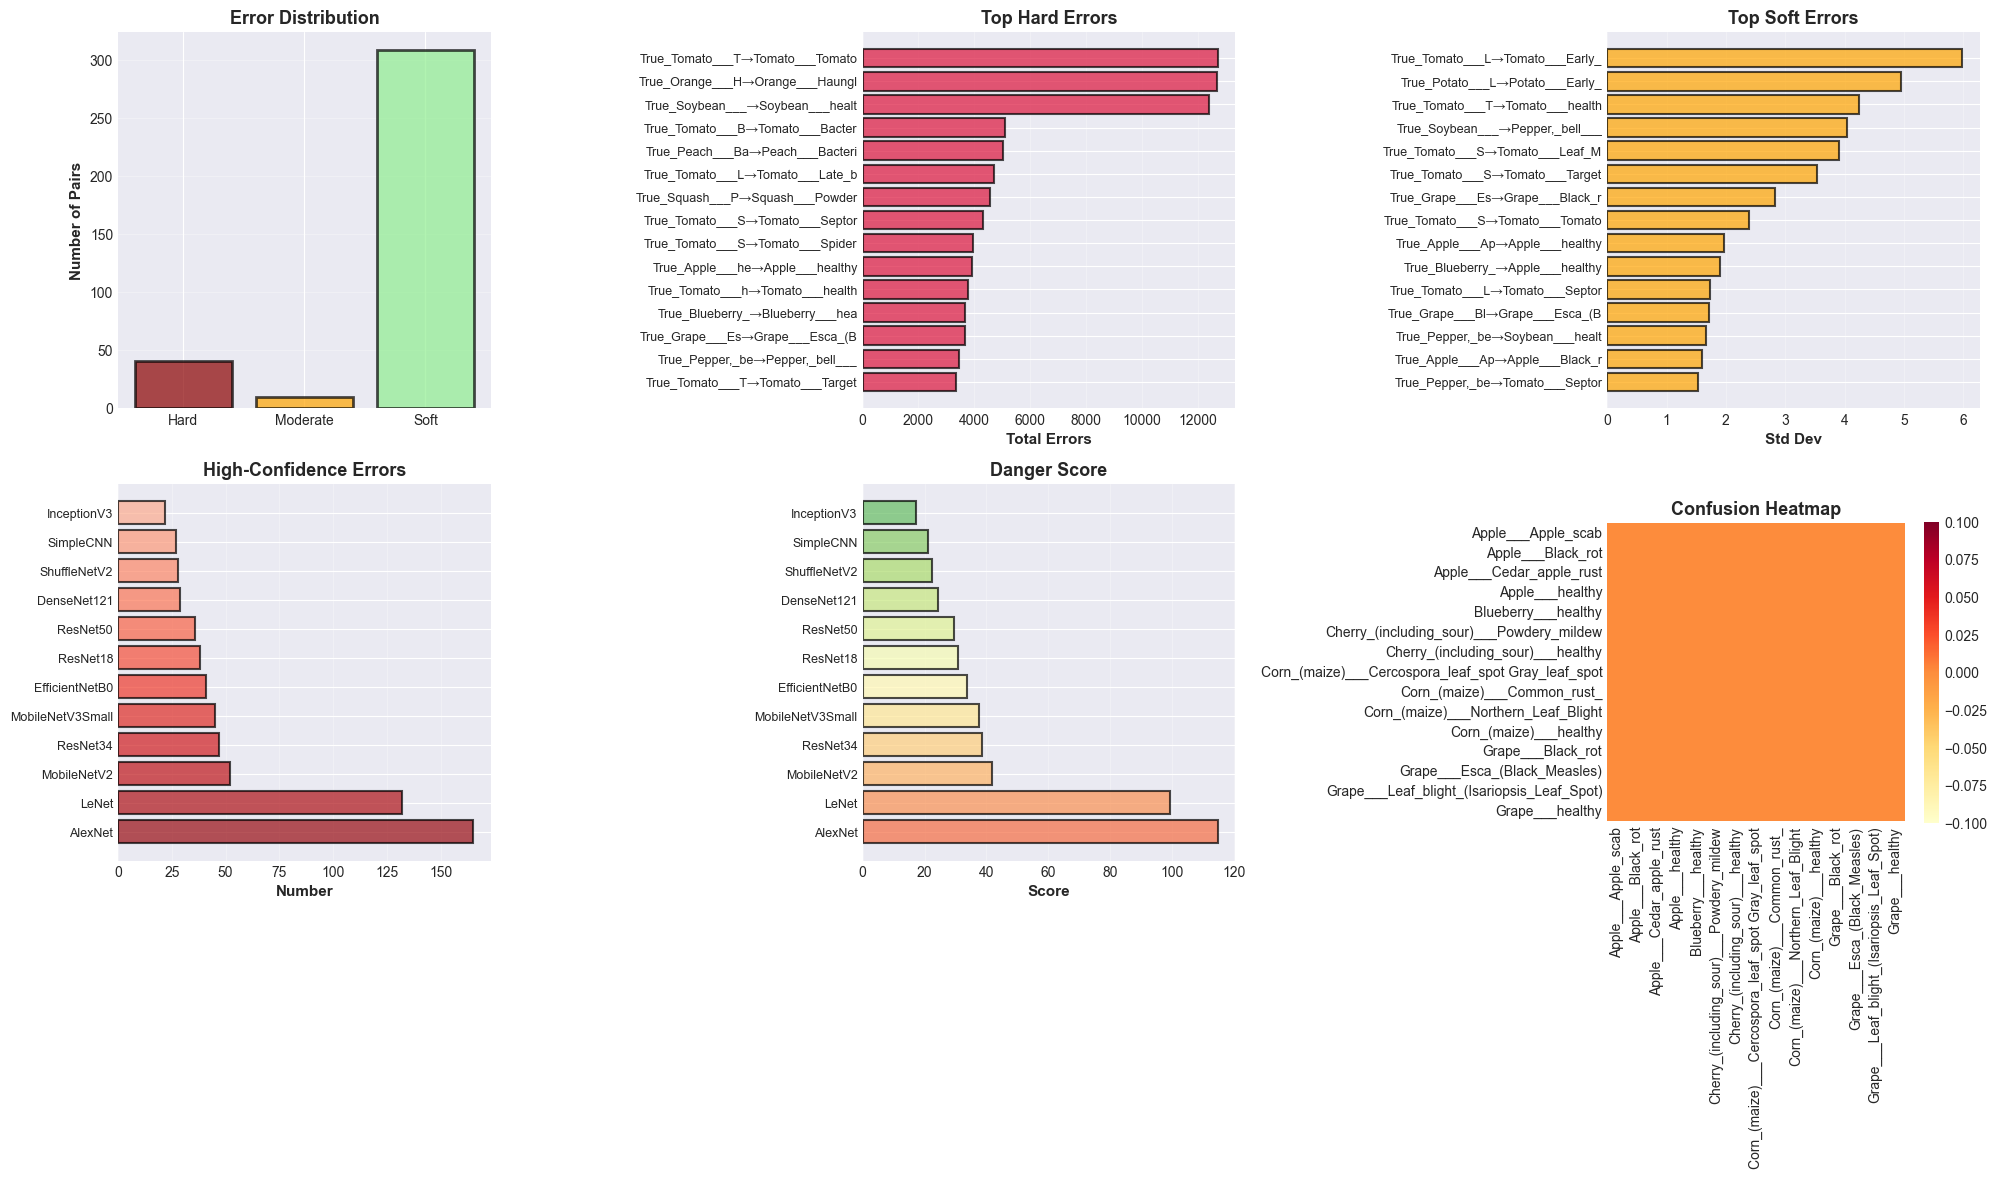

In [7]:
# Create Visualizations
print_subsection_header("6. CREATING VISUALIZATIONS")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Error distribution
ax1 = axes[0, 0]
error_dist = pd.DataFrame({
    'Type': ['Hard', 'Moderate', 'Soft'],
    'Count': [len(hard_errors), len(moderate_errors), len(soft_errors)]
})
colors_dist = ['darkred', 'orange', 'lightgreen']
ax1.bar(error_dist['Type'], error_dist['Count'], 
        color=colors_dist, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Number of Pairs', fontsize=11, fontweight='bold')
ax1.set_title('Error Distribution', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Top hard errors
ax2 = axes[0, 1]
top_hard = hard_errors.head(15)
y_labels = [f"{truncate_label(row['True_Class'], 15)}→{truncate_label(row['Predicted_Class'], 15)}" 
            for _, row in top_hard.iterrows()]
create_horizontal_bar(ax2, top_hard['Total_Count'].values, y_labels,
                     'Top Hard Errors', 'Total Errors', 'crimson')

# Plot 3: Top soft errors
ax3 = axes[0, 2]
top_soft = soft_errors.head(15)
y_labels_soft = [f"{truncate_label(row['True_Class'], 15)}→{truncate_label(row['Predicted_Class'], 15)}" 
                 for _, row in top_soft.iterrows()]
create_horizontal_bar(ax3, top_soft['Std_Count'].values, y_labels_soft,
                     'Top Soft Errors', 'Std Dev', 'orange')

# Plot 4: High-confidence errors
ax4 = axes[1, 0]
create_horizontal_bar(ax4, 
                     high_conf_analysis['High_Confidence_Errors'].sort_values().values,
                     high_conf_analysis.sort_values('High_Confidence_Errors')['Model'].values,
                     'High-Confidence Errors', 'Number',
                     plt.cm.Reds(np.linspace(0.3, 0.9, len(high_conf_analysis))))

# Plot 5: Danger score
ax5 = axes[1, 1]
create_horizontal_bar(ax5,
                     high_conf_analysis['Danger_Score'].sort_values().values,
                     high_conf_analysis.sort_values('Danger_Score')['Model'].values,
                     'Danger Score', 'Score',
                     plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(high_conf_analysis))))

# Plot 6: Confusion heatmap
ax6 = axes[1, 2]
if len(all_classes) > 15:
    top_confused = confusion_similarity.sum(axis=1).nlargest(15).index
    conf_subset = confusion_similarity.loc[top_confused, top_confused]
else:
    conf_subset = confusion_similarity

sns.heatmap(conf_subset, annot=False, cmap='YlOrRd', ax=ax6, 
            square=True, cbar_kws={"shrink": 0.8})
ax6.set_title('Confusion Heatmap', fontsize=13, fontweight='bold')

save_figure('step4_error_types.png')
plt.show()

In [8]:
# Save Results
print_subsection_header("7. SAVING RESULTS")

save_csv(hard_errors, 'step4_hard_errors.csv')
save_csv(soft_errors, 'step4_soft_errors.csv')
save_csv(high_conf_analysis, 'step4_high_confidence_errors.csv')
save_csv(confusion_similarity, 'step4_confusion_similarity.csv')

# Summary
print_section_header("PART 4 COMPLETE!")

print(f"\nKEY FINDINGS:")
print(f"  - Hard errors: {len(hard_errors)} pairs")
print(f"  - Soft errors: {len(soft_errors)} pairs")
print(f"  - Most dangerous: {high_conf_analysis.iloc[0]['Model']}")
print(f"  - Danger score: {high_conf_analysis.iloc[0]['Danger_Score']:.2f}")


--------------------------------------------------------------------------------
7. SAVING RESULTS
--------------------------------------------------------------------------------
Saved CSV: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\reports\step4_hard_errors.csv
Saved CSV: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\reports\step4_soft_errors.csv
Saved CSV: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\reports\step4_high_confidence_errors.csv
Saved CSV: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\reports\step4_confusion_similarity.csv

PART 4 COMPLETE!

KEY FINDINGS:
  - Hard errors: 41 pairs
  - Soft errors: 309 pairs
  - Most dangerous: AlexNet
  - Danger score: 114.65
